In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.utils import to_categorical
# importing the library
import tensorflow as tf
from tensorflow.keras import Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

from keras.models import Sequential

In [2]:
dirname = os.path.join(os.getcwd(), 'Datasets')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  D:\Data_Science\Pruebas\Davivienda\Ejercicio_1_Imagenes\Notebook\Datasets\
D:\Data_Science\Pruebas\Davivienda\Ejercicio_1_Imagenes\Notebook\Datasets\Blanco 1
D:\Data_Science\Pruebas\Davivienda\Ejercicio_1_Imagenes\Notebook\Datasets\Documentos 147
Directorios leidos: 2
Imagenes en cada directorio [148, 99]
suma Total de imagenes en subdirs: 247


In [3]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))

deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1
    
y = np.array(labels)
X = np.array(images, dtype=np.uint8)
#X = np.array(images, dtype=np.uint8) #convierto de lista a numpy

# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Cantidad etiquetas creadas:  247
0 Blanco
1 Documentos
Total number of outputs :  2
Output classes :  [0 1]


In [4]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

Training data shape :  (197, 400, 250, 3) (197,)
Testing data shape :  (50, 400, 250, 3) (50,)
Original label: 0
After conversion to one-hot: [1. 0.]
(157, 400, 250, 3) (40, 400, 250, 3) (157, 2) (40, 2)


# Al cambiar el número de ventanas de 8 a 16 y el tamaño de kernel de 3,7 a 5 tiene mejor rendimiento y ajuste la red

In [5]:
INIT_LR = 1e-3
epochs = 50
batch_size = 16

sport_model = Sequential()
sport_model.add(Conv2D(16, kernel_size=(5, 5),activation='linear',padding='same',input_shape=(400,250,3)))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(MaxPooling2D((2, 2),padding='same'))
sport_model.add(Dropout(0.5))

sport_model.add(Flatten())
sport_model.add(Dense(16, activation='linear'))
sport_model.add(LeakyReLU(alpha=0.1))
sport_model.add(Dropout(0.5)) 
sport_model.add(Dense(nClasses, activation='softmax'))

sport_model.summary()

sport_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 250, 16)      1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 400, 250, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 125, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 200, 125, 16)      0         
                                                                 
 flatten (Flatten)           (None, 400000)            0         
                                                                 
 dense (Dense)               (None, 16)                6400016   
                                                        

C:\Users\davze\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adagrad.py:77: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [6]:
sport_train = sport_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("docs_modelClass.h5py")

Epoch 1/50
10/10 [==============================] - 9s 135ms/step - loss: 3.5924 - accuracy: 0.4968 - val_loss: 1.4740 - val_accuracy: 0.4750
Epoch 2/50
10/10 [==============================] - 1s 57ms/step - loss: 0.9922 - accuracy: 0.6115 - val_loss: 0.7193 - val_accuracy: 0.4750
Epoch 3/50
10/10 [==============================] - 1s 57ms/step - loss: 1.0003 - accuracy: 0.5541 - val_loss: 0.6811 - val_accuracy: 0.5250
Epoch 4/50
10/10 [==============================] - 1s 57ms/step - loss: 0.8170 - accuracy: 0.5860 - val_loss: 0.7937 - val_accuracy: 0.4750
Epoch 5/50
10/10 [==============================] - 1s 58ms/step - loss: 0.8073 - accuracy: 0.4968 - val_loss: 0.8068 - val_accuracy: 0.4750
Epoch 6/50
10/10 [==============================] - 1s 55ms/step - loss: 0.6830 - accuracy: 0.6178 - val_loss: 0.6875 - val_accuracy: 0.4750
Epoch 7/50
10/10 [==============================] - 1s 52ms/step - loss: 2.0938 - accuracy: 0.5414 - val_loss: 0.7447 - val_accuracy: 0.5250
Epoch 8/50
1

INFO:tensorflow:Assets written to: docs_modelClass.h5py\assets


INFO:tensorflow:Assets written to: docs_modelClass.h5py\assets


In [7]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

2/2 [==============================] - 1s 178ms/step - loss: 0.0844 - accuracy: 0.9600
Test loss: 0.0844181701540947
Test accuracy: 0.9599999785423279


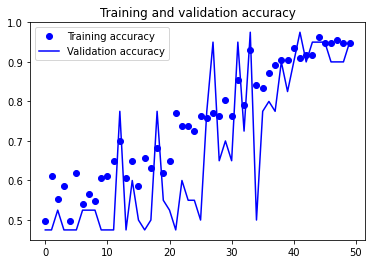

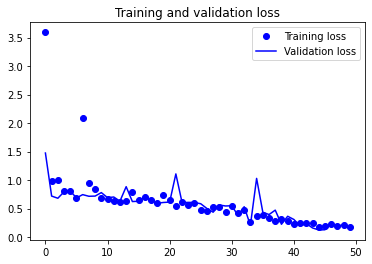

In [8]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
predicted_classes2 = sport_model.predict(test_X)

2/2 [==============================] - 1s 282ms/step


In [10]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [11]:
predicted_classes.shape, test_Y.shape

((50,), (50,))

Found 48 correct labels


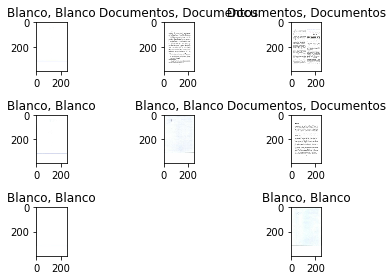

In [13]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(400,250,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 2 incorrect labels


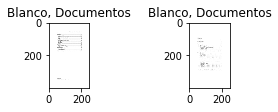

In [14]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(400,250,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [15]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.93      1.00      0.96        27
     Class 1       1.00      0.91      0.95        23

    accuracy                           0.96        50
   macro avg       0.97      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50



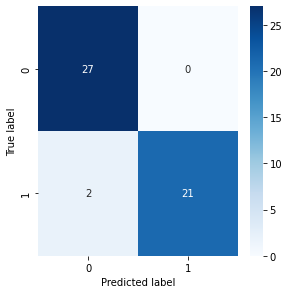

In [16]:
mat_tf=tf.math.confusion_matrix(
    test_Y,
    predicted_classes,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.float32,
    name=None
)

con_mat_df = pd.DataFrame(mat_tf,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
#y_pred=sport_model.predict(test_X)
con_mat = tf.math.confusion_matrix(labels=test_Y, predictions=predicted_classes).numpy()
#valid_label
#test_Y_one_hot

In [18]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

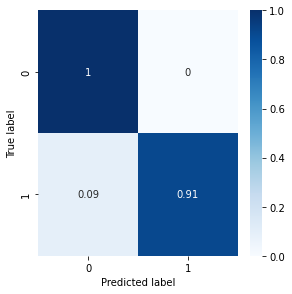

In [19]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()